In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse




start man in black shirt is standing on rocks end


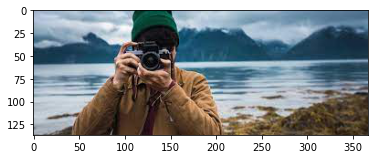

In [8]:

img_path ="D:\python-project-image-caption-generator\image19.jpg"

def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)

        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)


In [1]:
from nltk.translate.bleu_score import corpus_bleu

In [2]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over each image in the test set
    for key, desc_list in descriptions.items():
        yhat=generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))


In [3]:
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions

In [4]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

def load_photo_features(filename , dataset):
    all_features = load(open(filename,'rb'))
    features = {k : all_features[k] for k in dataset}
    return features


In [36]:
dataset_text = "D:\python-project-image-caption-generator\Flickr8k_text"
filename = dataset_text + "/" + "Flickr_8k.testImages.txt"
test = load_photos(filename)
test_descriptions = load_clean_descriptions('descriptions.txt', test)
test_features = load_photo_features('features.p', test)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


BLEU-1: 0.369504
